# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

from os import getcwd
from absl import logging
logging.set_verbosity(logging.ERROR)

print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.10.0
• GPU Device Found.


## Image Augmentation (v2)

In [2]:
target_size = (224,224)

# Data Directory
data_dir = "data"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        data_dir + "/train",  # This is the source directory for training images
        target_size=target_size,  # All images will be resized to 150x150
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='sparse')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        data_dir + "/val",
        target_size=target_size,
        batch_size=10,
        class_mode='sparse',
        shuffle=False
        )

test_generator = test_datagen.flow_from_directory(
        data_dir + "/test",
        target_size=target_size,
        batch_size=10,
        class_mode='sparse',
        shuffle=False
        )

Found 14000 images belonging to 28 classes.
Found 397 images belonging to 28 classes.
Found 409 images belonging to 28 classes.


# Modelling

In [3]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
def create_pre_trained_model():
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                  include_top = False)

  for layer in pre_trained_model.layers:
    layer.trainable = True

  return pre_trained_model

In [5]:
pre_trained_model = create_pre_trained_model()

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [6]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """
  last_desired_layer = pre_trained_model.get_layer('mixed9')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [7]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 5, 5, 2048)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 2048), dtype=tf.float32, name=None), name='mixed9/concat:0', description="created by layer 'mixed9'")


In [8]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(64, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.3)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(28, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = Adam(learning_rate=1e-4),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])


  return model

In [9]:
model = create_final_model(pre_trained_model, last_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                


                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                                 
                                                                                                  
 activation (Activation)        (None, 111, 111, 32  0           ['batch_normalization[0][0]']    
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 109, 109, 32  9216        ['activation[0][0]']             
                                )                                                                 
          

In [10]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
    )

# Train your model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

Epoch 1/100
280/280 [==============================] - ETA: 0s - loss: 0.8573 - accuracy: 0.7850

C:\Users\Destiny\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


280/280 [==============================] - 68s 215ms/step - loss: 0.8573 - accuracy: 0.7850 - val_loss: 0.4287 - val_accuracy: 0.9043
Epoch 2/100
280/280 [==============================] - 59s 212ms/step - loss: 0.1014 - accuracy: 0.9758 - val_loss: 0.2915 - val_accuracy: 0.9068
Epoch 3/100
280/280 [==============================] - 59s 212ms/step - loss: 0.0624 - accuracy: 0.9839 - val_loss: 0.5767 - val_accuracy: 0.8942
Epoch 4/100
280/280 [==============================] - 59s 212ms/step - loss: 0.0544 - accuracy: 0.9864 - val_loss: 0.4862 - val_accuracy: 0.8791
Epoch 5/100
280/280 [==============================] - 59s 212ms/step - loss: 0.0541 - accuracy: 0.9849 - val_loss: 0.5793 - val_accuracy: 0.8665
Epoch 6/100
280/280 [==============================] - 60s 214ms/step - loss: 0.0442 - accuracy: 0.9876 - val_loss: 0.5580 - val_accuracy: 0.8715
Epoch 7/100
280/280 [==============================] - 59s 210ms/step - loss: 0.0470 - accuracy: 0.9859 - val_loss: 0.5654 - val_accurac

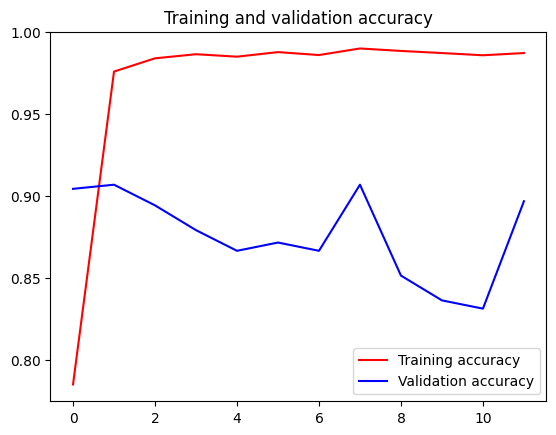

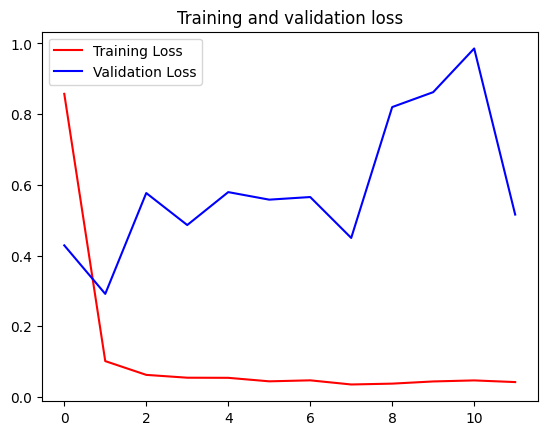

In [11]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

17/41 [===========>..................] - ETA: 0s

C:\Users\Destiny\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 [==============================] - 2s 37ms/step
Accuracy: 0.9437652811735942
Recall: 0.9437652811735942
Precision: 0.9486290858135682
F1-score: 0.9439668148177267


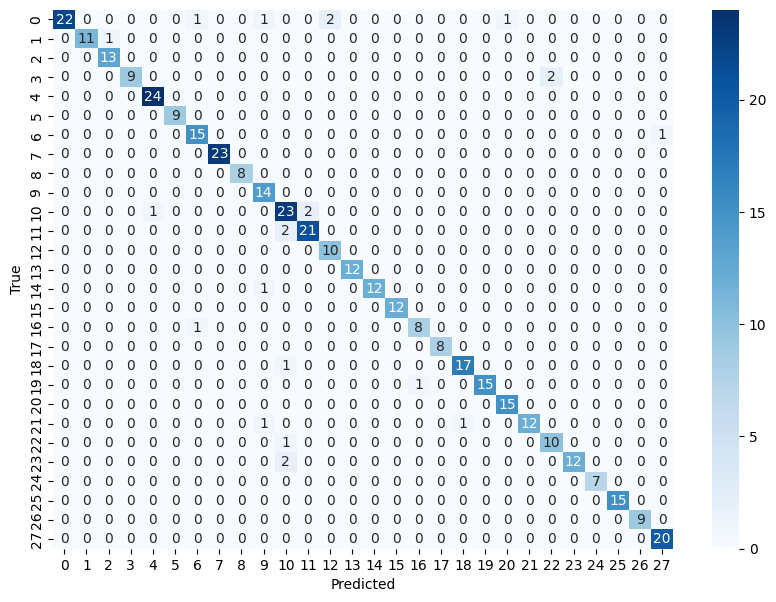

In [12]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the validation data and get predictions
test_labels = test_generator.classes
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_classes)

# Calculate accuracy, recall, precision, and f1-score
accuracy = accuracy_score(test_labels, test_pred_classes)
recall = recall_score(test_labels, test_pred_classes, average='weighted')
precision = precision_score(test_labels, test_pred_classes, average='weighted')
f1 = f1_score(test_labels, test_pred_classes, average='weighted')

# Print the metrics
print('=============================')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1-score: {f1}')
print('=============================')

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Save Model to tflite

In [13]:
# Konverter model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model telah dikonversi dan disimpan sebagai model.tflite")

INFO:tensorflow:Assets written to: C:\Users\Destiny\AppData\Local\Temp\tmpd0zkfc_w\assets


INFO:tensorflow:Assets written to: C:\Users\Destiny\AppData\Local\Temp\tmpd0zkfc_w\assets


Model telah dikonversi dan disimpan sebagai model.tflite


Save Model to tfjs

In [14]:
# # Assume `model` is your trained Keras model
# model.save('saved_model')

In [15]:
# !pip install tensorflowjs
# !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model

Model to json & Weight to h5

In [16]:
# # Assume `model` is your trained Keras model
# model_json = model.to_json()

# # Save the model architecture to a JSON file
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
    
# # Save the weights of the model to an HDF5 file
# model.save_weights("weight.1.h5")

Model to h5 & pkl

In [17]:
# Simpan model sebagai file .h5
model.save('model.h5')

import tensorflow as tf
import pickle

# Muat model dari file .h5
loaded_model = tf.keras.models.load_model('model.h5')

# Simpan model ke file pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(loaded_model, file)

INFO:tensorflow:Assets written to: ram://4e214f29-32fb-40ca-85cd-fe46bb52b8ed/assets


INFO:tensorflow:Assets written to: ram://4e214f29-32fb-40ca-85cd-fe46bb52b8ed/assets
